In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [38]:
CaseName_Base = 'RTS24_mod1'

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",
                 Folder_B: "OPC",
                 Folder_D: "R&D",
                 Folder_E: "OPT_LB",
                 Folder_K: "Hourly_inv",
                 Folder_L: "CHI",

                }

In [39]:
def LoadingData(dir, folder,result, case, ncluster, cm,folder_out = "4.OutWoInv"):
    #If the folder is A, the name is slightly different (no ByStages in the name and not dependent on nb clust)
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, folder_out, f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), folder_out, f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
    df['Number of clusters'] = ncluster
    df = df.reset_index()

    return df

#Load the weights of the representative periods 
def LoadingWeights(dir, folder, case, ncluster):
    if folder == 'A.The_full_year_MILP': 
        df_stage = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Stage_'+case+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Duration_'+case+'.csv'))
    else: 
        df_stage = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Stage_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Duration_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
    durations_filtered = df_duration[df_duration['Duration'] == 1]
    merged_df = pd.merge(df_stage, durations_filtered, left_on='Unnamed: 0', right_on='Stage', how='left')

    return merged_df


In [40]:
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250, 300,350, 400]
#nbs_clusters = [(i+1)*10 for i in range(2)]

#folders = [Folder_JB, Folder_JD,Folder_JE,Folder_JL]#,Folder_E,Folder_F,Folder_G]
folders = [Folder_A,Folder_B,Folder_D,Folder_E,Folder_L,Folder_K]
folders = [Folder_A]#,Folder_B,Folder_D,Folder_E,Folder_L,Folder_K]

#folders = [Folder_A,Folder_L,Folder_JL,Folder_D,Folder_JD,Folder_B,Folder_JB,Folder_E,Folder_JE]
results = ["NetworkFlowPerNode"]

results_dfs = dict()
weights_dfs = dict()
results_w_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    weights_dfs[result] = dict()
    results_w_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        results_w_dfs[result][folder] = dict()
        weights_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            try: 
                results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])
                if not(folder.startswith("J")):
                    weights_dfs[result][folder][nb_clusters] = LoadingWeights(DirName,folder,CaseName_Base,nb_clusters)
                    results_w_dfs[result][folder][nb_clusters] = results_dfs[result][folder][nb_clusters].merge(weights_dfs[result][folder][nb_clusters][["LoadLevel","Weight"]],on= "LoadLevel")
                                        
            except FileNotFoundError as e : 
                print(e)
                print(folder,nb_clusters, "Does not contain", result)
def get_overall_avg_utilization(df_utilization): 
    return df_utilization["GWh"].mean()

def get_weighted_overall_avg_Utilization(df_util,df_weights):
    merged_df = df_util.merge(df_weights,how = "left",on = "LoadLevel")
    merged_df["GWh_weighted"] = merged_df["GWh"] * merged_df["Weight"]
    return merged_df["GWh_weighted"].sum()/merged_df["Weight"].sum()

In [41]:
# Initialize DataFrames to store results
overal_avg_flows = pd.DataFrame()
all_flows = pd.DataFrame()
i = 0

# Loop through each folder and number of clusters
for folder in folders:
    print(folder)
    for nb_clusters in nbs_clusters:
        # Calculate the overall average utilization
        overall_avg_util = get_overall_avg_utilization(results_dfs[result][folder][nb_clusters])
        
        # Calculate the weighted overall average utilization if necessary
        if folder.startswith("J."):
            overall_weighted_utilization = overall_avg_util
        else:
            overall_weighted_utilization = get_weighted_overall_avg_Utilization(
                results_dfs[result][folder][nb_clusters],
                weights_dfs[result][folder][nb_clusters]
            )
        
        # Create a new row with the calculated values
        row = pd.DataFrame({
            "Clustering method": category_dict[folder],
            "Number of clusters": nb_clusters,
            "Avg_util": overall_avg_util,
            "Avg_util_w": overall_weighted_utilization
        }, index=[i])
        i += 1
        
        # Concatenate the new row to the overall summary DataFrame
        overal_avg_flows = pd.concat([overal_avg_flows, row])
        
        # Concatenate the individual results to the all_utils DataFrame
        #all_utils = pd.concat([all_utils, results_dfs[result][folder][nb_clusters]])
        all_flows = pd.concat([all_flows, results_w_dfs[result][folder][nb_clusters]])

A.The_full_year_MILP


In [42]:
def extract_FYMILP_one_line(all_utils_FYMILP,node_pair): 
    filter_this_line = (all_utils_FYMILP["InitialNode"] == node_pair[0]) & (all_utils_FYMILP["FinalNode"] == node_pair[1])
    utils_this_line_FYMILP = all_utils_FYMILP[filter_this_line]

    ts_this_line_FYMILP = utils_this_line_FYMILP.GWh.to_numpy()
    return ts_this_line_FYMILP

def extract_CM_one_line(cm,nbc): 
    ts_CM_All_lines = pd.read_csv(f"Y.FYTS_from_ByStages/{CaseName_Base}/{cm}/Flow_per_node_nc{nbc}.csv",header = [0,1],index_col=0)
    ts_this_line_CM = ts_CM_All_lines.loc[:,node_pair].to_numpy()
    return ts_this_line_CM

In [43]:
## Extract fyts for multiple lines 


## FYMILP
filter_FYMILP = (all_flows["Clustering method"] == "FYMILP") & (all_flows["Number of clusters"] == 10) & (all_flows["Circuit"] == "eac1") 

all_flows_FYMILP = all_flows[filter_FYMILP]
unique_node_pairs = [tuple(x) for x in all_flows_FYMILP[['InitialNode', 'FinalNode']].drop_duplicates().values.tolist()]


##CM 
cm = "OPT_LB"
nbc = 10

nb_lines = len(unique_node_pairs)
ts_all_lines_CM=np.zeros(8736*nb_lines)
ts_all_lines_FYMILP=np.zeros(8736*nb_lines)

for i,node_pair in enumerate(unique_node_pairs[:nb_lines]): 
    ts_this_line_FYMILP = extract_FYMILP_one_line(all_flows_FYMILP,node_pair)
    ts_this_line_CM = extract_CM_one_line(cm,nbc)
    i_start = i*8736
    i_end = (i+1)*8736
    ts_all_lines_FYMILP[i_start:i_end]=ts_this_line_FYMILP
    ts_all_lines_CM[i_start:i_end] = ts_this_line_CM
    
np.corrcoef(ts_all_lines_FYMILP,ts_all_lines_CM)

array([[1.      , 0.548189],
       [0.548189, 1.      ]])

# Flow correlations 

In [44]:
## Extract fyts for multiple lines 


## FYMILP
filter_FYMILP = (all_flows["Clustering method"] == "FYMILP") & (all_flows["Number of clusters"] == 10) & (all_flows["Circuit"] == "eac1") 

all_flows_FYMILP = all_flows[filter_FYMILP]
unique_node_pairs = [tuple(x) for x in all_flows_FYMILP[['InitialNode', 'FinalNode']].drop_duplicates().values.tolist()]
nb_lines = len(unique_node_pairs)

correls_v,total_diffs_v,total_devs_v,nbcs_v,cms_v = [],[],[],[],[]


##CM 
cm = "OPT_LB"
for cm in ["R&D","CHI","OPT_LB","HI","OPC"]:
    for nbc in [10,20,50,100,200]:


        ts_all_lines_CM=np.zeros(8736*nb_lines)
        ts_all_lines_FYMILP=np.zeros(8736*nb_lines)

        for i,node_pair in enumerate(unique_node_pairs[:nb_lines]): 
            ts_this_line_FYMILP = extract_FYMILP_one_line(all_flows_FYMILP,node_pair)
            ts_this_line_CM = extract_CM_one_line(cm,nbc)
            i_start = i*8736
            i_end = (i+1)*8736
            ts_all_lines_FYMILP[i_start:i_end]=ts_this_line_FYMILP
            ts_all_lines_CM[i_start:i_end] = ts_this_line_CM

        total_dev= np.sum(np.abs((ts_all_lines_CM-ts_all_lines_FYMILP)))
        correlation = np.corrcoef(ts_all_lines_FYMILP,ts_all_lines_CM)[0,1]

        cms_v.append(cm)
        nbcs_v.append(nbc)
        
        total_flow = np.sum((np.abs((ts_all_lines_FYMILP))))

        correls_v.append(correlation)
        total_diffs_v.append(total_dev)
        total_devs_v.append(total_dev/total_flow)

df = pd.DataFrame({"CM":cms_v,"nbc":nbcs_v,"Correlation": correls_v,"Total diff":total_diffs_v,"Total dev":total_devs_v})

<Axes: xlabel='nbc', ylabel='Total dev'>

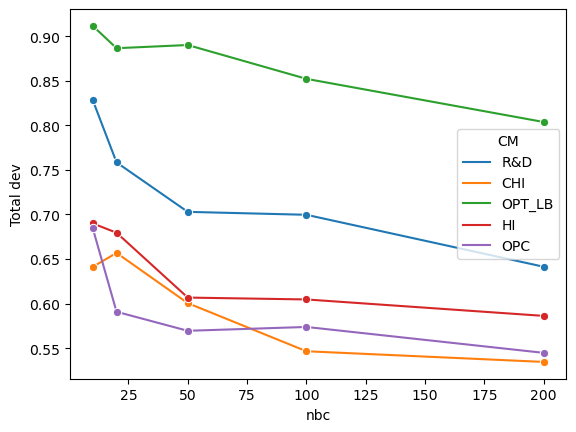

In [48]:
x = "nbc"
y= "Total dev"
sns.lineplot(data = df,x = x, y = y,hue = "CM",marker = "o")


In [74]:
df[df.CM == "R&D"]

,CM,nbc,Correlation,Total diff,Total dev
0,R&D,10,0.662288,16443.213048,0.828082
1,R&D,20,0.676477,15060.163003,0.758432
2,R&D,50,0.687668,13958.430080,0.702948
3,R&D,100,0.689018,13893.071876,0.699657
4,R&D,200,0.724479,12735.079919,0.641340


In [98]:
## Export for latex figure 

y = "Total dev"
x = "Number of clusters"

if CaseName_Base.endswith("mod1"): 
    correl = "LC"
else:
    correl = "HC"

        
# Directory to save CSV files
output_dir = "Z.Figures/data_for_latex"
os.makedirs(output_dir, exist_ok=True)
nbcs = [10,20,40,60,80,100,150,200,250,300,350,400]
# Export data for each case
if CaseName_Base.startswith("IEEE"):
    nbcs = [10,20,30,40,50,60,70,80,90,100]
else:
    nbcs = [10,20,50,40,60,80,100,150,200,250,300,350,400]
for cm in ["R&D","OPT_LB","CHI","OPC","HI"]:
    rf = df[df.CM == cm]
    rf.set_index("nbc", inplace=True)
    csv_file = os.path.join(output_dir, f"{CaseName_Base.replace('_', '').replace('mod1', '')}_{cm.replace('_', '').replace('&', '')}_{correl}_flowdev.csv")
    rf[rf.index.isin(nbcs)]["Total dev"].to_csv(csv_file)

In [97]:
rf[rf.index.isin(nbcs)]

,CM,nbc,Correlation,Total diff,Total dev
